In [59]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS


In [162]:
# mean and stdev for fields in imdb dataset
imdb_year_stats = (1994.89, 25.97)
imdb_avgrat_stats = (6.19, 1.37)
imdb_numrat_stats = (3657.33, 35609.24)
# box office stats taken from this kaggle dataset
# https://www.kaggle.com/datasets/kalilurrahman/top-box-office-revenue-data-english-movies?resource=download
# and computed from 'Worldwide Lifetime Gross' of top 1000 international movies
# ofc that doesn't add up because we took other stats from all movies and this stat from the most successful
# TODO maybe turn it down a notch and make a mean of idk 1M dollars instead of 400 but increase std
imdb_boxoffice_stats = (404658884.85, 291795184.03 )
# with these it should be possible to recreate real-looking data from zscores, right? multiply by std, add mean.

# some set stats from the imdb dataset
imdb_top_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Crime']
imdb_top_genres_freq = [0.46, 0.25, 0.16, 0.11, 0.1, 0.09]

stats={
    'year': imdb_year_stats,
    'avg_rating': imdb_avgrat_stats,
    'num_ratings': imdb_numrat_stats,
    'boxoffice': imdb_boxoffice_stats,
    'top_genres':imdb_top_genres,
    'imdb_top_genres_freq':imdb_top_genres_freq
}

In [278]:
# year, avg_rating, num_ratings, box office dollars
cov = [
        [1, 0, .3, .2],
        [0, 1, .5, .4],
        [.3, .5, 1, .2],
        [.2, .4, .2, 1]
    ]
cov = [ [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
dist1 = sps.multivariate_normal(
    mean=[0,0,0, 0],
    cov=cov
)
dist2 = sps.multivariate_normal(
    mean=[0,2,2,0],
    cov=cov
)

nd1 = 20
nd2 = 5
samples = np.concatenate(
    (dist1.rvs(size=nd1, random_state=1), dist2.rvs(size=nd2, random_state=1))
)
w = imdb_year_stats[0] + (samples[:,0] * imdb_year_stats[1])
x = imdb_avgrat_stats[0] + (samples[:,1] * imdb_avgrat_stats[1])
y = imdb_numrat_stats[0] + (samples[:,2] * imdb_numrat_stats[1])
z = imdb_boxoffice_stats[0] + (samples[:,3] * imdb_boxoffice_stats[1])
t = np.concatenate( (np.repeat(0, nd1), np.repeat(1,nd2)))
df = pd.DataFrame(data={'year':w, 'avg_rating':x, 'num_ratings':y, 'box_office':z, 't': t})

for i,g in enumerate(imdb_top_genres):
    freq = imdb_top_genres_freq[i]
    df[g] = sps.binom.rvs(1,freq,size=nd1+nd2)

# now a bit of postprocessing
# no negative numbers
df = np.abs(df)
# year and num_rating and box office can't be float
for field in ['year','num_ratings','box_office']:
    df[field] = df[field].apply(lambda y: int(y))
# some floats should be rounded
df['avg_rating']=df['avg_rating'].round(1)
# regarding sets
# we want all sets to have at least one element in each cluster
# which at the same time ensures that no set has a single or no element
genre_colsums = df[imdb_top_genres+['t']].groupby('t').sum()
for cluster in range(2):
    for genre in imdb_top_genres:
        count = genre_colsums.loc[cluster,genre]
        if count == 0:
            # take random row of that cluster and add the set there
            randrow_start = 0 if cluster == 0 else nd1
            randrow_end = nd1 if cluster == 0 else nd1+nd2
            randrow = np.random.choice(range(randrow_start, randrow_end), 1, replace=False)
            df.loc[randrow[0], genre] = 1
# do the same sort of thing row-wise
# there could be movies not in any set/genre, and we don't want that
for i in range(df.shape[0]):
    while df.loc[i][imdb_top_genres].sum() < 1:
        for j,genre in enumerate(imdb_top_genres):
            # do the drawing again
            freq = imdb_top_genres_freq[j]
            flag = sps.binom.rvs(1,freq,size=1)
            df.loc[i,genre]=flag

df


,year,avg_rating,num_ratings,box_office,t,Drama,Comedy,Documentary,Romance,Action,Crime
0,2037,5.4,15150,91571808,0,1,0,0,0,0,0
1,2017,3.0,65788,182542377,0,1,0,0,0,0,1
2,2003,5.8,55721,196480252,0,1,0,0,0,0,0
3,1986,5.7,44029,83715910,0,0,0,1,0,0,0
4,1990,5.0,5160,574721557,0,0,0,1,0,0,0
5,1966,7.8,35762,551284312,0,1,0,0,0,0,1
6,2018,5.3,718,131605870,0,1,0,0,0,1,0
7,1987,6.9,20972,288888116,0,1,0,0,0,0,0
8,1977,5.0,20245,400963415,0,0,1,0,0,0,0
9,1965,6.5,62761,621183797,0,0,0,1,0,0,0


In [251]:
# load imdb dataset to get little known movie names
ratings = pd.read_csv('../imdb/title.ratings.tsv', sep='\t')
movies = pd.read_csv('../imdb/title.basics.tsv', sep="\t", header=0, converters={
    # sucks, but it's mixed data everywhere
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': str,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': str,
    'genres': str,
})
movies = movies.query('(isAdult == "0") & (titleType == "movie")')
movie_ratings = pd.merge(ratings, movies, how='inner', on='tconst')
movie_ratings['year'] = movie_ratings['startYear'].apply(lambda s: int(s) if s != '\\N' else -1)
movie_ratings = movie_ratings[movie_ratings['year']>0]
genres = movie_ratings.genres.str.split(',').apply(lambda x:set(x))
all_genres = list(set.union(*genres))
setdist_table = [
    list(map(lambda ag: 1 if ag in i else 0, all_genres)) for i in genres
]
setdist_table = np.array(setdist_table)
set_colsum = np.sum(setdist_table, axis=0)
top_genres = list(sorted(all_genres, key=lambda g: set_colsum[all_genres.index(g)], reverse=True))[:6]
for genre in all_genres:
    movie_ratings[f'{genre}'] = setdist_table[:,all_genres.index(genre)]
# remove the remaining maybe-porns
movie_ratings = movie_ratings.query('Adult == 0')
# now filter for little-known movies, i.e., those with few ratings
movie_ratings = movie_ratings.query('numVotes < 1000')
movie_ratings

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,History,Music,Thriller,Action,Biography,Sport,Musical,Drama,Talk-Show,Western
0,tt0000009,5.3,206,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,...,0,0,0,0,0,0,0,0,0,0
1,tt0000147,5.3,474,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,...,0,0,0,0,0,1,0,0,0,0
2,tt0000502,4.1,15,movie,Bohemios,Bohemios,0,1905,\N,100,...,0,0,0,0,0,0,0,0,0,0
3,tt0000574,6.0,832,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,...,0,0,0,1,1,0,0,0,0,0
4,tt0000591,4.4,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289320,tt9916170,7.0,7,movie,The Rehearsal,O Ensaio,0,2019,\N,51,...,0,0,0,0,0,0,0,1,0,0
289321,tt9916190,3.7,243,movie,Safeguard,Safeguard,0,2020,\N,95,...,0,0,1,1,0,0,0,0,0,0
289324,tt9916428,3.8,14,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,...,1,0,0,0,0,0,0,0,0,0
289325,tt9916538,8.6,7,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,...,0,0,0,0,0,0,0,1,0,0


In [298]:
# now group and sort movies by genres and take random names from the dataset
from functools import reduce
df['genre_sets'] = reduce(lambda s,g: s+df[g].astype('str'),imdb_top_genres, df[imdb_top_genres[0]].astype('str'))
df['genre_sets'] = df['genre_sets'].apply(lambda gs: gs[1:])

for genre_combo in sorted(df.genre_sets.unique(), key=lambda gs: gs.count('1'), reverse=True):
    qs = ' & '.join(map(lambda gf: f'{imdb_top_genres[gf[0]]} == {gf[1]}', enumerate(list(genre_combo))))
    movie_subset = movie_ratings.query(qs)
    num_titles_req = len(df[df.genre_sets == genre_combo])
    randtitles = np.random.choice(movie_subset['primaryTitle'].to_list(), num_titles_req, replace=False)
    df.loc[df['genre_sets'] == genre_combo, 'title']= randtitles
df



Drama == 1 & Comedy == 1 & Documentary == 0 & Romance == 0 & Action == 0 & Crime == 1
Drama == 1 & Comedy == 0 & Documentary == 0 & Romance == 0 & Action == 1 & Crime == 1
Drama == 1 & Comedy == 0 & Documentary == 0 & Romance == 0 & Action == 0 & Crime == 1
Drama == 1 & Comedy == 0 & Documentary == 0 & Romance == 0 & Action == 1 & Crime == 0
Drama == 0 & Comedy == 0 & Documentary == 1 & Romance == 1 & Action == 0 & Crime == 0
Drama == 1 & Comedy == 0 & Documentary == 0 & Romance == 1 & Action == 0 & Crime == 0
Drama == 0 & Comedy == 1 & Documentary == 0 & Romance == 1 & Action == 0 & Crime == 0
Drama == 0 & Comedy == 1 & Documentary == 1 & Romance == 0 & Action == 0 & Crime == 0
Drama == 1 & Comedy == 0 & Documentary == 0 & Romance == 0 & Action == 0 & Crime == 0
Drama == 0 & Comedy == 0 & Documentary == 1 & Romance == 0 & Action == 0 & Crime == 0
Drama == 0 & Comedy == 1 & Documentary == 0 & Romance == 0 & Action == 0 & Crime == 0


,year,avg_rating,num_ratings,box_office,t,Drama,Comedy,Documentary,Romance,Action,Crime,genre_sets,num_sets,title
0,2037,5.4,15150,91571808,0,1,0,0,0,0,0,100000,1,1+1=3 Ora Tinjon
1,2017,3.0,65788,182542377,0,1,0,0,0,0,1,100001,2,King of the Gamblers
2,2003,5.8,55721,196480252,0,1,0,0,0,0,0,100000,1,Pride of the Blue Grass
3,1986,5.7,44029,83715910,0,0,0,1,0,0,0,001000,1,Attenborough's Paradise Birds
4,1990,5.0,5160,574721557,0,0,0,1,0,0,0,001000,1,A Crack in the Mountain
5,1966,7.8,35762,551284312,0,1,0,0,0,0,1,100001,2,I Was a Shoplifter
6,2018,5.3,718,131605870,0,1,0,0,0,1,0,100010,2,Chathurangam
7,1987,6.9,20972,288888116,0,1,0,0,0,0,0,100000,1,Dust
8,1977,5.0,20245,400963415,0,0,1,0,0,0,0,010000,1,In the Beginning There Was Underwear
9,1965,6.5,62761,621183797,0,0,0,1,0,0,0,001000,1,411 Productions Presents: 61: The Bam Issue


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

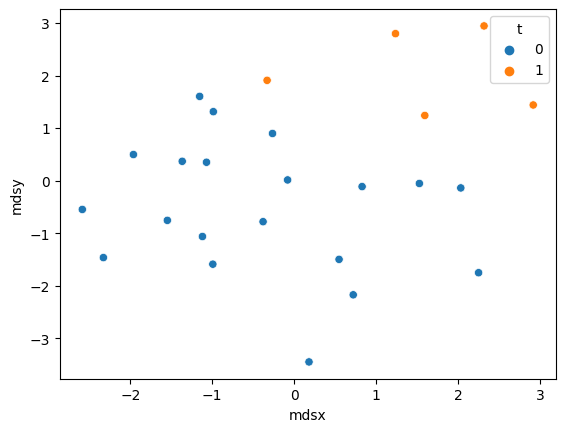

In [238]:
mds = MDS(n_components=2, metric=True, random_state=2,  dissimilarity="euclidean")
H_mds = mds.fit_transform(samples)

sns.scatterplot(pd.DataFrame(data={
    'mdsx': H_mds[:,0], 
    'mdsy': H_mds[:,1], 
    't': t,
    'w': w,
    'x': x,
    'y': y,
    'z': z
}), x='mdsx', y='mdsy', hue='t')
